<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [3]:
import os
import pandas as pd

# 1. 导入数据
path = r"../data/"
origin_file = "comment_nm.xlsx"
comments_df = pd.read_excel(os.path.join(path, origin_file), encoding="utf8")
comments_df.shape
print(comments_df.shape, comments_df.head())
# 留个备份, 这样之后覆盖写错了就不用重新覆盖
comments_df2 = comments_df.copy()


(77273, 8)      团购活动ID       用户ID     用户名                 评价时间                      评价内容  \
0  10051080  437407990  嗯****～  2018-04-04 08:35:30          这家店竟然没有玉米饼和杠子馍。。   
1  10051080  434997839  露****4  2017-10-25 08:18:22           味道很不错，今天还要再去，很棒   
2  10051080  424757158  礼****来  2017-01-19 02:38:39      很划算，适合5、6个人吃不浪费，很喜欢！   
3  10051080  424646918  请****7  2017-01-17 09:15:15           味道不错，喜欢吃肉的朋友可以去   
4  10051080  423190677  1****0  2016-12-26 01:43:18  环境优雅，爱吃肉的朋友可以去体验一下，味道不错！   

   评分         消费门店   用户排名  
0   4  姥家大锅台(交通路店)  10161  
1   5  姥家大锅台(交通路店)   9681  
2   5  姥家大锅台(交通路店)   8847  
3   5  姥家大锅台(交通路店)   8835  
4   5  姥家大锅台(交通路店)   8772  


In [ ]:

# 2. 清洗数据, 删除空的数据
def clean_sents(txt):
    txt = str(txt) if txt is not None else ""
    if len(txt) == 0:
        return None
    else:
        return txt

comments_df2["评价内容"] = comments_df2["评价内容"].apply(clean_sents)
comments_df2 = comments_df2[comments_df2["评价内容"] != "nan"]
len(comments_df2)

In [ ]:

# 2. 引入停用词文本
import jieba

stopwords_file = "stopwords.txt"
with open(os.path.join(path, stopwords_file), "r", encoding="utf8") as f:
    stopwords_list = [word.strip() for word in f.read()]


In [9]:

def filter_stopwords(txt):
    """过滤停用词"""
    sent = jieba.lcut(txt)
    words = []
    for word in sent:
        word = word.strip()
        if(word in stopwords_list):
            continue
        else:
            words.append(word)
    return words

comments_df2["评价内容"] = comments_df2["评价内容"].apply(filter_stopwords)
comments_df2.head()


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Public\Documents\Wondershare\CreatorTemp\jieba.cache
Loading model cost 1.207 seconds.
Prefix dict has been built succesfully.


,团购活动ID,用户ID,用户名,评价时间,评价内容,评分,消费门店,用户排名
0,10051080,437407990,嗯****～,2018-04-04 08:35:30,"[这家, 店, 竟然, 没有, 玉米饼, 杠子, 馍]",4,姥家大锅台(交通路店),10161
1,10051080,434997839,露****4,2017-10-25 08:18:22,"[味道, 很, 不错, 今天, 还要, 去, 很棒]",5,姥家大锅台(交通路店),9681
2,10051080,424757158,礼****来,2017-01-19 02:38:39,"[很, 划算, 适合, 个人, 吃, 浪费, 很, 喜欢]",5,姥家大锅台(交通路店),8847
3,10051080,424646918,请****7,2017-01-17 09:15:15,"[味道, 不错, 喜欢, 吃, 肉, 朋友, 可以, 去]",5,姥家大锅台(交通路店),8835
4,10051080,423190677,1****0,2016-12-26 01:43:18,"[环境, 优雅, 爱, 吃, 肉, 朋友, 可以, 去, 体验, 一下, 味道, 不错]",5,姥家大锅台(交通路店),8772


In [10]:

# 3. 切分训练集和验证集和测试集
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(comments_df2["评价内容"], comments_df2["评分"], test_size=0.3)
val_X, test_X, val_y, test_y = train_test_split(val_X, val_y, test_size=0.5)


[('很', 23350),
 ('不错', 21834),
 ('味道', 17218),
 ('吃', 15025),
 ('好吃', 11842),
 ('环境', 9027),
 ('服务', 9025),
 ('去', 9000),
 ('可以', 7723),
 ('都', 7231)]

In [ ]:
# 4. 统计词频
from nltk import FreqDist

all_words = []
for comment in comments_df2["评价内容"]:
    all_words.extend(comment)

len(all_words)

fdisk = FreqDist(all_words)
TOP_COMMON_WORDS = 1000
most_common_words = fdisk.most_common(TOP_COMMON_WORDS)
most_common_words[:10]


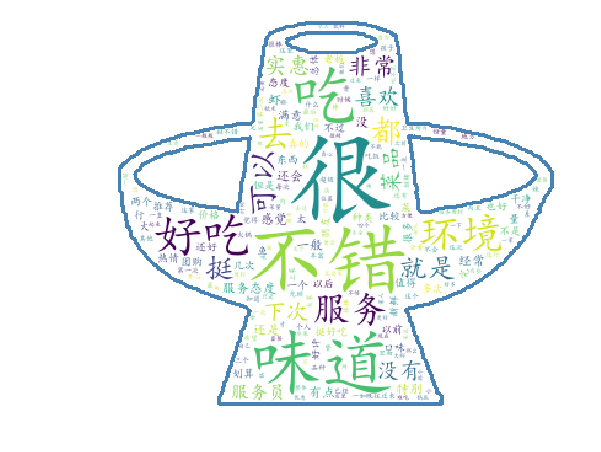

In [14]:
# 5. 生成前N个高频词的词云
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

mask = np.array(Image.open(os.path.join(path, "火锅图片.png")))
wc = WordCloud(font_path=os.path.join(path, "simkai.ttf"),
               background_color="white",
               contour_width=3,
               contour_color='steelblue',
               mask=mask,
               width=1000,
               height=1000)

wc.generate_from_frequencies(dict(most_common_words))
fig = plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis("off")
plt.savefig(os.path.join(path, "火锅词云.png"), dpi=1000)
plt.show()



In [ ]:
# 生成TF-IDF和词袋模型
# TODO 用nltk调用tf-idf
from nltk.text import TextCollection

tfidf_generator = TextCollection(comments_df2["评价内容"].values.tolist())

def extract_tfidf(text_df, text_collection, common_words):
    """
    提取文本的tf-idf.
        text_df: 输入文本的Series.
        text_collection: 预先初始化的TextCollection.
        common_words: 输入的前N个词作为特征进行计算.
    """
    n_sample = text_df.shape[0]
    n_feat = len(common_words)

    X = np.zeros([n_sample, n_feat])
    y = np.zeros(n_sample)
    for i, text in enumerate(text_df["评价内容"]):
        if i % 5000 == 0:
            print("已经完成{}个样本的特征提取.".format(i))

        feature_vector = []
        for word in common_words:
            if word in text:
                tf_idf = text_collection.tf_idf(word, text)
            else:
                tf_idf = 0.0

            feature_vector.append(tf_idf)

        X[i, :] = np.array(feature_vector)
        y[i] = text_df["评分"].iloc[i]

    return X, y

cleaned_train_X, cleaned_train_y = extract_tfidf(comments_df2, tfidf_generator, common_words)
